# Imports

In [2]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt

In [3]:
from dataclasses import dataclass

from src.mutant import Mutant
from src.test import Test




ModuleNotFoundError: No module named 'src.test'

In [243]:
def generate_repo_diff_data(repo: Repo, mutant_id=-1):
    current_diff = repo.index.diff(None)
    diff = repo.git.diff(repo.head, None)
    patchset = PatchSet(diff)
    
    print(patchset[0].target_file)
    modified_file_path = patchset[0].target_file[2:] # Remove b/ from the path
    changed_sourcecode_line = patchset[0][0].source_start
    previous_line = ''
    change_to_line = ''
    for line in patchset[0][0]:
        if line.is_added:
            changed_to_line = str(line)[2:]
        if line.is_removed:
            previous_line = str(line)[2:]
    
    return Mutant(mutant_id, modified_file_path, changed_sourcecode_line, previous_line, changed_to_line)

#print(analyze_change_in_working_directory(repo).__dict__)

In [244]:
def generate_test_data(mutant_id=-1):
    with open('repos/flask/report.json') as json_file:
        data = json.load(json_file)["report"]
#         print(json.dumps(data, indent=2))
        test_runs = []
        for json_test in data["tests"]:
             test_runs.append(Test.fromJson(json_test))
        return test_runs
        

In [250]:
!cd repos/flask/ && pytest --json=report.json --timeout=300

============================= test session starts ==============================
platform linux -- Python 3.8.1, pytest-5.4.2, py-1.8.1, pluggy-0.13.1
rootdir: /mnt/brick/home/dmeier/CRM2020/repos/flask, inifile: setup.cfg, testpaths: tests
plugins: timeout-1.3.4, json-report-1.2.1, json-0.4.0, metadata-1.9.0
timeout: 300.0s
timeout method: signal
timeout func_only: False
collected 468 items                                                            

tests/test_appctx.py ..............                                      [  2%]
tests/test_basic.py .................................................... [ 14%]
......................................................................   [ 29%]
tests/test_blueprints.py ............................................... [ 39%]
.                                                                        [ 39%]
tests/test_cli.py .........................................ss.s......    [ 50%]
tests/test_config.py ................                           

In [251]:
with open('repos/flask/report.json') as json_file:
    print(json.load(json_file)["report"]["tests"][0])

{'name': 'tests/test_appctx.py::test_basic_url_generation', 'duration': 0.004573345184326172, 'run_index': 0, 'setup': {'name': 'setup', 'duration': 0.0018436908721923828, 'outcome': 'passed'}, 'call': {'name': 'call', 'duration': 0.0006525516510009766, 'outcome': 'passed'}, 'teardown': {'name': 'teardown', 'duration': 0.0002334117889404297, 'outcome': 'passed'}, 'outcome': 'passed'}


In [245]:
mutants = pd.DataFrame(columns=['mutant_id','modified_file_path','line_number_changed','previous_line', 'current_line'])
mutants
test_runs = pd.DataFrame(columns=['test_id', 'mutant_id', 'outcome'])

"failed" == "failed"

True

In [246]:
def analyze_mutant(*,mutant_id):
    repo = Repo("repos/flask")
    assert not repo.bare
    !echo Switching to Mutant $mutant_id
    !. crm2020_python3.8/bin/activate && cd repos/flask/ && mutmut apply $mutant_id && pytest --json=report.json > /dev/null
    changed_file = generate_repo_diff_data(repo= repo, mutant_id=mutant_id)
    tests = generate_test_data(mutant_id=mutant_id)
    
    # Cleanup logic:
    !cd repos/flask/ && git checkout .
    !rm repos/flask/report.json
    
    return {"changed_file": changed_file, "tests": tests}
    
# analyze_mutant(mutant_id=1)

In [247]:
tests = pd.DataFrame(columns=Test.__annotations__)
mutants = pd.DataFrame(columns=Mutant.__annotations__)

for mutant_id in range(1, 2, 1):
    try:
        results = analyze_mutant(mutant_id=mutant_id)
        for test in results["tests"]:
            tests = tests.append(test.__dict__, ignore_index = True)
        mutants = mutants.append(results["changed_file"].__dict__, ignore_index=True)
        print("Tests length: " + str(len(tests)))
    except:
        print("Unexpected error:", sys.exc_info()[0])
        print("Resetting the repo and then testing the next mutant")
        !cd repos/flask/ && git checkout .


Switching to Mutant 1
b/src/flask/app.py
Tests length: 468


In [248]:
tests

,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
0,True,0,tests/test_appctx.py::test_basic_url_generation,test_basic_url_generation,tests/test_appctx.py,0.003975,True,0.001587,True,0.000592947,True,0.000208378
1,True,1,tests/test_appctx.py::test_url_generation_requ...,test_url_generation_requires_server_name,tests/test_appctx.py,0.002659,True,0.001115,True,0.000249624,True,0.000180483
2,True,2,tests/test_appctx.py::test_url_generation_with...,test_url_generation_without_context_fails,tests/test_appctx.py,0.000828,True,0.000251,True,0.000160456,True,0.000165462
3,True,3,tests/test_appctx.py::test_request_context_mea...,test_request_context_means_app_context,tests/test_appctx.py,0.002968,True,0.001097,True,0.00058341,True,0.000190258
4,True,4,tests/test_appctx.py::test_app_context_provide...,test_app_context_provides_current_app,tests/test_appctx.py,0.003050,True,0.001356,True,0.000160694,True,0.000177145
...,...,...,...,...,...,...,...,...,...,...,...,...
463,True,463,tests/test_views.py::test_explicit_head,test_explicit_head,tests/test_views.py,0.004402,True,0.001329,True,0.00151491,True,0.000228882
464,True,464,tests/test_views.py::test_endpoint_override,test_endpoint_override,tests/test_views.py,0.005579,True,0.001246,True,0.00287104,True,0.000215054
465,True,465,tests/test_views.py::test_methods_var_inheritance,test_methods_var_inheritance,tests/test_views.py,0.004526,True,0.001351,True,0.00158238,True,0.000241995
466,True,466,tests/test_views.py::test_multiple_inheritance,test_multiple_inheritance,tests/test_views.py,0.005246,True,0.001344,True,0.00232792,True,0.000229597


In [249]:
mutants

,mutant_id,modified_file_path,line_number_changed,previous_line,current_line
0,1,src/flask/app.py,54,sentinel = object()\n,sentinel = None\n


In [ ]:
mutants_and_tests = mutants.set_index('mutant_id').join(tests.set_index('mutant_id'))
# mutants_and_tests.to_pickle('flask_dataset_every_mutant_with_checkout_on_failure.pkl')

In [ ]:
mutants_and_tests.groupby(['test_id','outcome']).count()['current_line']


In [74]:
# Covariance Matrix 
mutants_and_tests = pd.read_pickle('20200604-001227joined_data')
mutants_and_tests.reset_index()
mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
mutants_and_tests["outcome"].loc[mutants_and_tests["outcome"] == False]

mutant_id
1       False
1       False
1       False
1       False
1       False
        ...  
1234    False
1234    False
1234    False
1234    False
1234    False
Name: outcome, Length: 84, dtype: bool

,modified_file_path,line_number_changed,previous_line,current_line,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
mutant_id,,,,,,,,,,,,,,,,
1,src/flask/config.py,9,,self.__name__ = None\n,True,0,tests/test_appctx.py::test_basic_url_generation,test_basic_url_generation,tests/test_appctx.py,0.007523,True,0.003278,True,0.000736,True,0.000231
1,src/flask/config.py,9,,self.__name__ = None\n,True,1,tests/test_appctx.py::test_url_generation_requ...,test_url_generation_requires_server_name,tests/test_appctx.py,0.003607,True,0.001565,True,0.000260,True,0.000216
1,src/flask/config.py,9,,self.__name__ = None\n,True,2,tests/test_appctx.py::test_url_generation_with...,test_url_generation_without_context_fails,tests/test_appctx.py,0.000993,True,0.000324,True,0.000161,True,0.000185
1,src/flask/config.py,9,,self.__name__ = None\n,True,3,tests/test_appctx.py::test_request_context_mea...,test_request_context_means_app_context,tests/test_appctx.py,0.004140,True,0.001608,True,0.000709,True,0.000215
1,src/flask/config.py,9,,self.__name__ = None\n,True,4,tests/test_appctx.py::test_app_context_provide...,test_app_context_provides_current_app,tests/test_appctx.py,0.003985,True,0.001772,True,0.000204,True,0.000237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,src/flask/testing.py,66,,"sep = b""?"" if isinstance(url.qu...",True,463,tests/test_views.py::test_explicit_head,test_explicit_head,tests/test_views.py,0.005416,True,0.001683,True,0.001799,True,0.000251
1234,src/flask/testing.py,66,,"sep = b""?"" if isinstance(url.qu...",True,464,tests/test_views.py::test_endpoint_override,test_endpoint_override,tests/test_views.py,0.006971,True,0.001561,True,0.003595,True,0.000255
1234,src/flask/testing.py,66,,"sep = b""?"" if isinstance(url.qu...",True,465,tests/test_views.py::test_methods_var_inheritance,test_methods_var_inheritance,tests/test_views.py,0.005810,True,0.001828,True,0.001915,True,0.000239


test_id,1,2,3,4,5,6,7,8,9,10,...,458,459,460,461,462,463,464,465,466,467
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN
1868,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
1869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN
1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN


In [79]:
pivot = pivot.astype('bool')

test_id,1,2,3,4,5,6,7,8,9,10,...,458,459,460,461,462,463,464,465,466,467
test_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


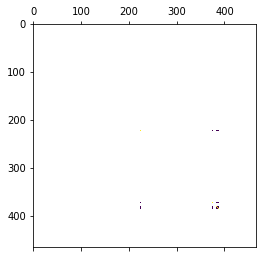

In [6]:
display(pivot.cov())

plt.matshow(pivot.corr())
plt.show()

,index,mutant_id,current_line,line_number_changed,modified_file_path,previous_line,outcome,test_id,full_name,name,filepath,duration,setup_outcome,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration
225,225,1.0,self.__name__ = None\n,9.0,src/flask/config.py,,False,225,tests/test_cli.py::test_load_dotenv,test_load_dotenv,tests/test_cli.py,0.000633,False,0.000215,None,NaN,None,NaN
226,226,1.0,self.__name__ = None\n,9.0,src/flask/config.py,,False,226,tests/test_cli.py::test_dotenv_path,test_dotenv_path,tests/test_cli.py,0.000585,False,0.000194,None,NaN,None,NaN
228,228,1.0,self.__name__ = None\n,9.0,src/flask/config.py,,False,228,tests/test_cli.py::test_disable_dotenv_from_env,test_disable_dotenv_from_env,tests/test_cli.py,0.000635,False,0.000225,None,NaN,None,NaN
311,311,1.0,self.__name__ = None\n,9.0,src/flask/config.py,,False,311,tests/test_helpers.py::TestStreaming::test_str...,TestStreaming::test_streaming_with_context,tests/test_helpers.py,0.006654,True,0.002401,False,0.001521,None,NaN
312,312,1.0,self.__name__ = None\n,9.0,src/flask/config.py,,False,312,tests/test_helpers.py::TestStreaming::test_str...,TestStreaming::test_streaming_with_context_as_...,tests/test_helpers.py,0.005803,True,0.001810,False,0.001634,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,2259,2000.0,if index is not None:\n,272.0,src/flask/json/tag.py,,False,387,tests/test_signals.py::test_flash_signal,test_flash_signal,tests/test_signals.py,0.000331,False,0.000105,None,NaN,None,NaN
2260,2260,2000.0,if index is not None:\n,272.0,src/flask/json/tag.py,,False,388,tests/test_signals.py::test_appcontext_tearing...,test_appcontext_tearing_down_signal,tests/test_signals.py,0.000322,False,0.000109,None,NaN,None,NaN
2265,2265,2000.0,if index is not None:\n,272.0,src/flask/json/tag.py,,False,393,tests/test_templating.py::test_standard_context,test_standard_context,tests/test_templating.py,0.005326,True,0.001742,False,0.001544,None,NaN
2310,2310,2000.0,if index is not None:\n,272.0,src/flask/json/tag.py,,False,438,tests/test_testing.py::test_full_url_request,test_full_url_request,tests/test_testing.py,0.006260,True,0.002023,False,0.001687,None,NaN


test_id,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
test_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


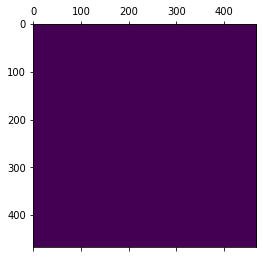

In [75]:
mutants_and_tests = pd.read_pickle('20200604-141344_joined_data.pkl').reset_index()
display(mutants_and_tests.loc[mutants_and_tests['outcome'] == False])
pivot = mutants_and_tests.reset_index().pivot(index='mutant_id', columns='test_id', values='outcome')
# pivot.drop(pivot.columns[0], axis=1, inplace=True)
display(pivot.cov(min_periods=12))
plt.matshow(pivot.cov())
plt.show()